In [28]:
%matplotlib inline

In [29]:
import numpy as np
import matplotlib.pylab as plt
from astropy import wcs
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits

from farm.miscellaneous.fits import hdr3d

fov = (0.05, 0.05)
cdelt = 0.01
freqs = [1e8, 1.1e8, 1.2e8]
target_ra, target_dec = 15.5 + 0. * cdelt + 0.00025, -1.5 - 0. * cdelt + 0.00025
coord0 = SkyCoord(15.5, -1.5, unit=(u.deg, u.deg), frame='fk5')
fits_file = '/Users/simon.purser/Desktop/test_fits_idxs.fits'

hdr = hdr3d(int(fov[0] // cdelt), int(fov[1] // cdelt), coord0, cdelt, freqs)
shape_data = (hdr['NAXIS3'], hdr['NAXIS2'], hdr['NAXIS1'])
# print(hdr)
wcs = wcs.WCS(hdr)
print(wcs)
# print(wcs.to_header())
# data_arr = np.arange(0, np.prod(shape_data), dtype=float).reshape(shape_data)
data_arr = np.zeros(shape_data)

# Note that pixel coordinates are assumed to be 0 at the center of the first
# pixel in each dimension
zz, yy, xx = np.meshgrid(np.arange(hdr['NAXIS3']),
                         np.arange(hdr['NAXIS2']),
                         np.arange(hdr['NAXIS1']), indexing='ij')
rra, ddec, ffreq = wcs.pixel_to_world_values(xx, yy, zz)

delta_ra = rra[0][0][1] - rra[0][0][0]
delta_dec = ddec[0][1][0] - ddec[0][0][0]

idxs = wcs.world_to_array_index_values(
    target_ra, target_dec, freqs[0]
)

hdu = fits.PrimaryHDU(data_arr)
hdu.header = hdr
hdu.writeto(fits_file, overwrite=True)

WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---SIN'  'DEC--SIN'  'FREQ'  
CRVAL : 15.5  -1.5  100000000.0  
CRPIX : 2.5  2.5  1.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : -0.01  0.01  10000000.0  
NAXIS : 5  5  3


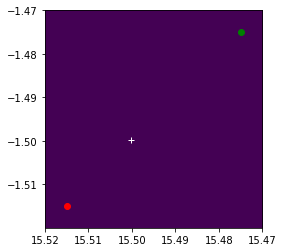

In [30]:
extent = (rra[0][0][0] - delta_ra / 2, rra[0][0][-1] + delta_ra / 2,
          ddec[0][-1, 0] + delta_dec / 2, ddec[0][0, 0] - delta_dec / 2)

plt.close('all')

plt.imshow(data_arr[0], extent=extent)
plt.ylim(plt.ylim()[::-1])
fits_idx_first_x, fits_idx_first_y, _ = wcs.pixel_to_world_values(0, 0, 0)
fits_idx_last_x, fits_idx_last_y, _ = wcs.pixel_to_world_values(
    hdr['NAXIS1'] - 1, hdr['NAXIS2'] - 1, 0
)
4
plt.plot(fits_idx_first_x, fits_idx_first_y, 'ro')
plt.plot(fits_idx_last_x, fits_idx_last_y, 'go');
plt.plot(target_ra, target_dec, 'w+')

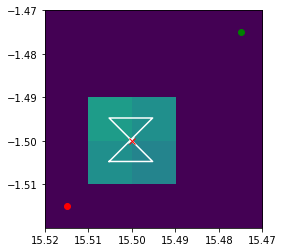

In [32]:
import numpy.typing as npt
from astropy.wcs import WCS


def place_point_source_on_grid(data: npt.NDArray, im_wcs: WCS, tgt_ra: float,
                               tgt_dec: float, tgt_flux0: float, tgt_freq0: float,
                               tgt_spix: float):
    """
    Given a coordinate for a point source, add it (in place) to the data array
    of fluxes

    Parameters
    ----------
    data
        Data array of fluxes
    im_wcs
        World coordinate system
    tgt_ra
        Source's right ascension [deg]
    tgt_dec
        Source's declination [deg]
    tgt_flux0
        Source's peak-flux/flux at freq0 [Jy]
    tgt_freq0
        Frequency of source's peak flux [Hz]
    tgt_spix
        Spectral index of source
    """
    im_hdr = im_wcs.to_header(relax=True)
    nfreq = im_wcs.spectral.array_shape[0]
    im_freqs = [im_hdr['CRVAL3'] + (n - im_hdr['CRPIX3'] + 1) * im_hdr['CDELT3']
                for n in range(nfreq)]

    # Get size of pixel in both RA and declination
    d_dec = im_hdr['CDELT2']
    d_ra = d_dec / np.cos(np.radians(tgt_dec))
    cell_area = np.abs(d_ra * d_dec)

    verts = np.array(
        [[[tgt_ra + d_ra / 2., tgt_dec - d_dec / 2.],
          [tgt_ra - d_ra / 2., tgt_dec - d_dec / 2.],
          [tgt_ra + d_ra / 2., tgt_dec + d_dec / 2.],
          [tgt_ra - d_ra / 2., tgt_dec + d_dec / 2.]]] * nfreq
    )
    ras = verts[:, :, 0].reshape((nfreq, 2, 2))
    decs = verts[:, :, 1].reshape((nfreq, 2, 2))
    freqs = np.concatenate([np.full((1, 2, 2), freq) for freq in im_freqs],
                           axis=0)
    crds = np.concatenate((ras[...,np.newaxis], decs[...,np.newaxis]), axis=3)

    idxs_verts = im_wcs.world_to_array_index_values(ras, decs, freqs)
    freq_idxs_verts, dec_idxs_verts, ra_idxs_verts = idxs_verts

    cell_crds = im_wcs.array_index_to_world_values(*idxs_verts)[:2]
    crd_intersection = np.mean(cell_crds, axis=(1, 2, 3))

    outside_arr = ((ra_idxs_verts >= data.shape[2]) |
                   (ra_idxs_verts < 0) |
                   (dec_idxs_verts >= data.shape[1]) |
                   (dec_idxs_verts < 0))

    # Do not add source if any part of it lies outside data array
    if True in outside_arr:
        return verts, crd_intersection

    offsets = crds - crd_intersection
    areas = np.abs(np.prod(offsets, axis=(3,))) / cell_area

    vals = areas[np.newaxis, ...] * tgt_flux0 * (np.array(im_freqs)[..., np.newaxis, np.newaxis] / tgt_freq0) ** tgt_spix
    data[idxs_verts] = vals

    return verts, crd_intersection


verts, coord_intersection = place_point_source_on_grid(data_arr, wcs, target_ra, target_dec, 1000., 1e8, -0.7)
hdu.writeto('/Users/simon.purser/Desktop/test.fits', overwrite=True)
verts = verts[0]

plt.close('all')

plt.imshow(data_arr[0], extent=extent, vmin=0, vmax=500)
plt.plot(fits_idx_first_x, fits_idx_first_y, 'ro')
plt.plot(fits_idx_last_x, fits_idx_last_y, 'go');
plt.plot(target_ra, target_dec, 'wx')
plt.plot(np.append(verts[:, 0], verts[:1, 0]), np.append(verts[:, 1], verts[:1, 1]), 'w-')
plt.plot(*coord_intersection, 'rx')
plt.ylim(plt.ylim()[::-1]);